## Predict Product Prices

Selecting our model and evaluating the base model against the task.

Keep in mind: our base model has 3 billion params, quantized down to 4 bits
Compared with GPT-4o at TRILLIONS of params!


In [8]:
# pip installs - ignore the error message!

!pip install -q datasets requests torch peft bitsandbytes transformers trl accelerate sentencepiece tiktoken matplotlib

In [9]:
# imports

import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, set_seed
from peft import LoraConfig, PeftModel
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
import matplotlib.pyplot as plt

In [10]:
# Tokenizers

LLAMA_3_1 = "meta-llama/Llama-3.2-1B"
QWEN_2_5 = "Qwen/Qwen2.5-7B"
GEMMA_2 = "google/gemma-2-9b"
PHI_3 = "microsoft/Phi-3-medium-4k-instruct"

# Constants

BASE_MODEL = LLAMA_3_1
HF_USER = "ed-donner"
DATASET_NAME = f"{HF_USER}/pricer-data"
MAX_SEQUENCE_LENGTH = 182
QUANT_4_BIT = True

# Used for writing to output in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

%matplotlib inline

### Log in to HuggingFace

In [11]:
# Log in to HuggingFace

hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

In [12]:
def investigate_tokenizer(model_name):
  print("Investigating tokenizer for", model_name)
  tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
  for number in [0, 1, 10, 100, 999, 1000]:
    tokens = tokenizer.encode(str(number), add_special_tokens=False)
    print(f"The tokens for {number}: {tokens}")

In [13]:
# Now we will try this with each model: LLAMA_3_1, QWEN_2_5, GEMMA_2, PHI_3

investigate_tokenizer(PHI_3)

Investigating tokenizer for microsoft/Phi-3-medium-4k-instruct
The tokens for 0: [29871, 29900]
The tokens for 1: [29871, 29896]
The tokens for 10: [29871, 29896, 29900]
The tokens for 100: [29871, 29896, 29900, 29900]
The tokens for 999: [29871, 29929, 29929, 29929]
The tokens for 1000: [29871, 29896, 29900, 29900, 29900]


# Load our data

We uploaded it to Hugging Face, so it's easy to retrieve it now

In [14]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

README.md:   0%|          | 0.00/416 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/185M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/914k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [15]:
test[0]

{'text': "How much does this cost to the nearest dollar?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K\n\nPrice is $",
 'price': 374.41}

# Prepare our Base Llama Model for evaluation

Load our base model with 4 bit quantization and try out 1 example

In [16]:
## pick the right quantization

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [17]:
# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:.1f} GB")

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

Memory footprint: 1.0 GB


In [18]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','').replace('$','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [19]:
extract_price("Price is $999 blah blah so cheap")

999.0

In [20]:
def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = base_model.generate(inputs, max_new_tokens=4, attention_mask=attention_mask, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

In [21]:
model_predict(test[0]['text'])

1999.0

# Evaluation!

Trying out our base Llama 3.1 model against the Test dataset

In [22]:
class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

1: Guess: $1,999.00 Truth: $374.41 Error: $1,624.59 SLE: 2.80 Item: OEM AC Compressor w/...
2: Guess: $7.00 Truth: $225.11 Error: $218.11 SLE: 11.17 Item: Motorcraft YB3125 Fa...
3: Guess: $7.99 Truth: $61.68 Error: $53.69 SLE: 3.77 Item: Dorman Front Washer ...
4: Guess: $299.00 Truth: $599.99 Error: $300.99 SLE: 0.48 Item: HP Premium HD Plus T...
5: Guess: $7.00 Truth: $16.99 Error: $9.99 SLE: 0.66 Item: Super Switch Pickup ...
6: Guess: $25.00 Truth: $31.99 Error: $6.99 SLE: 0.06 Item: Horror Bookmarks, Re...
7: Guess: $1,999.00 Truth: $101.79 Error: $1,897.21 SLE: 8.81 Item: SK6241 - Stinger 4 G...
8: Guess: $1,999.00 Truth: $289.00 Error: $1,710.00 SLE: 3.73 Item: Godox ML60Bi LED Lig...
9: Guess: $1,299.00 Truth: $635.86 Error: $663.14 SLE: 0.51 Item: Randall G3 Plus Comb...
10: Guess: $7.00 Truth: $65.99 Error: $58.99 SLE: 4.52 Item: HOLDWILL 6 Pack LED ...
11: Guess: $1,999.00 Truth: $254.21 Error: $1,744.79 SLE: 4.24 Item: Viking Horns 3 Gallo...
12: Guess: $7.00 Truth: $412.9

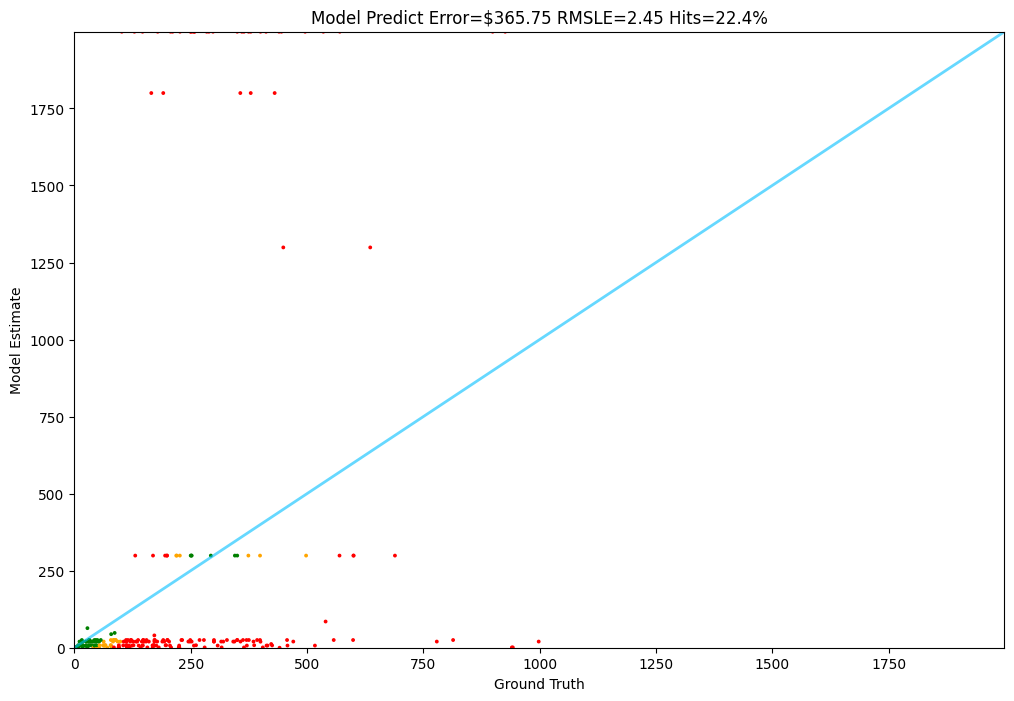

In [23]:
Tester.test(model_predict, test)